# Anaconda/Mac installation instructions
Download https://github.com/intel/mkl-dnn/releases/download/v0.12/mklml_mac_2018.0.1.20171227.tgz for later installation of install libmklml.dylib and libiomp5.dylib. Assuming standard paths and MacOS 10.14.1, enter these commands:
```
conda create -n mkl_tflow -y python=3.6 numpy protobuf==3.4.1
conda activate mkl_tflow
pip install https://github.com/anton-matosov/tensorflow-wheels/raw/master/Tensorflow-Wheels/MacOS/MKL/tensorflow-1.5.0-cp36-cp36m-macosx_10_7_x86_64.whl
pip install keras==2.1.6
pip install coremltools
cp ~/Downloads/mklml_mac_2018.0.1.20171227/lib/lib*.dylib /anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/
conda install jupyter matplotlib pillow pydot
pip install 
```
The above instructions are based on https://github.com/anton-matosov/tensorflow-wheels. Thanks for compiling Tensorflow with MKL and MacOS optimizations - this gives a 25% boost over the standard Anaconda Tensorflow 1.12.0 library.

For some strange reason, this notebook does not find keras when using `jupyter-lab`. However, it works flawlessly under `ipython notebook`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pwd
!rm -rf data
!mkdir data
!unzip -q '/content/gdrive/My Drive/Autonomes Fahrzeug/Trainingsdatensätze/20200906-132753-741.zip' -d 'data'
!ls data | wc -l

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1


In [ ]:
%matplotlib inline
from IPython.display import display, Image, SVG, clear_output
from ipywidgets import IntProgress
import os
import glob
import json
import PIL
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install -U coremltools==3.0b6 tensorflow==1.13.1 keras==2.2.4
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import tensorflow as tf

In [ ]:
import keras as keras

from keras.layers import Input
from keras.models import Model, load_model
from keras.layers import Convolution2D
from keras.layers import Dropout, Flatten, Dense, Cropping2D, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence
from keras.utils.vis_utils import model_to_dot

from keras import backend as K

In [ ]:
from platform import python_version
print("Python version", python_version())
print("numpy     ", np.__version__)
print("PIL       ", PIL.__version__)
print("Tensorflow", tf.__version__)
print("Keras     ", keras.__version__)

Python version 3.6.9
numpy      1.18.5
PIL        7.0.0
Tensorflow 2.3.0
Keras      2.4.3


In [ ]:
# Parameters for image overview plots
ncols = 8
nrows = 12
#ncols = 8
#nrows = 20

In [ ]:
# Model
STEERING_NUM_CATEGORIES = 15

In [ ]:
# Training process
BATCH_SIZE = 128
TRAIN_TEST_SPLIT = 0.8

In [ ]:
#MODEL_DIR = os.path.expanduser('~/git/af/JeepDriver/model')
#MODEL_DIR = '/content/gdrive/My Drive/nb/JeepDriver-model/JeepDriver-OHS-181123.zip'
#MODEL_DIR = '/content/data'
DATA_DIR = '/content/data'
NN_DIR = 'gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze'
MODEL_DIR = os.path.join(NN_DIR, 'Model')
ANDROID_DIR = os.path.join(NN_DIR, 'Android')
IOS_DIR = os.path.join(NN_DIR, 'IOS')
TFLITE_PATH = os.path.join(ANDROID_DIR, 'Test.tflite')#'model.tflite')
CHECKPOINT_PATH = os.path.join(MODEL_DIR, 'checkpoint.hdf5')
MODEL_PATH = os.path.join(MODEL_DIR, 'keras-model.hdf5')

In [ ]:
def get_filenames(directory_or_zipfile, fn_pattern='*'):
  import zipfile
  import fnmatch
  import glob

  if zipfile.is_zipfile(directory_or_zipfile):
    with zipfile.ZipFile(directory_or_zipfile) as zf:
      fns = zf.namelist()
      print(fns)
    fns = [ fn for fn in fns if fnmatch.fnmatch(fn, fn_pattern) ]
  else:
    fns = [ os.path.basename(fn) for fn in glob.glob(directory_or_zipfile) ]
    print(fns)
    fns = [ os.path.basename(fn) for fn in glob.glob(os.path.join(directory_or_zipfile, fn_pattern)) ]
  return sorted(fns)

In [ ]:
def get_names(dir, fn_pattern='*'):
  import fnmatch
  import os

  matches = []
  for root, dirnames, filenames in os.walk(dir):
    for filename in fnmatch.filter(filenames, fn_pattern):
        matches.append(os.path.join(root, filename))

  return matches

In [ ]:
def read_json_file(directory_or_zipfile, fn):
  import zipfile
  import json

  if zipfile.is_zipfile(directory_or_zipfile):
    with zipfile.ZipFile(directory_or_zipfile) as zf:
      with zf.open(fn) as f:
        json_data = json.loads(f.read())
  else:
    with open(os.path.join(directory_or_zipfile, fn), encoding='utf-8') as f:
      json_data = json.loads(f.read())
  return json_data

In [ ]:
def read_image_file(directory_or_zipfile, filename):
  import zipfile
  from io import BytesIO
  from PIL import Image

  if zipfile.is_zipfile(directory_or_zipfile):
    with zipfile.ZipFile(directory_or_zipfile) as zf:
      data = BytesIO(zf.read(filename))  # seekable
      image_pil = Image.open(data)
  else:
    image_pil = Image.open(os.path.join(directory_or_zipfile, filename))

  if image_pil.mode != 'RGB':
      image_pil = image_pil.convert(mode='RGB')
  size = image_pil.size[1], image_pil.size[0], 3
  image = np.frombuffer(image_pil.tobytes(), dtype='uint8').reshape(size)
  #image = image[40:90, :]
  return image

In [ ]:
# demonstrate the above functions
json_fn_pattern = 'train-*.json'
json_fns = get_names(DATA_DIR, json_fn_pattern)
print("{} files matching the '{}' pattern found in '{}'.".format(len(json_fns), json_fn_pattern, DATA_DIR))
print("json_fns[0] = '{}'".format(json_fns[0]))

20529 files matching the 'train-*.json' pattern found in '/content/data'.
json_fns[0] = '/content/data/20200906-132753-741/Json/train-06092020-133824-240.json'


Investigating '/content/data/20200906-132753-741/Json/train-06092020-133824-240.json' with image file '/content/data/20200906-132753-741/Picture/train-06092020-133824-240.jpg'.
{'steering': 0.41960788, 'throttle': 0.41176468, 'timestamp': 1599392304240, 'image': '/content/data/20200906-132753-741/Picture/train-06092020-133824-240.jpg'}
Image shape (50, 160, 3) strides (480, 3, 1)


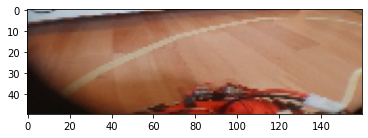

In [ ]:
json_fn = json_fns[0]
dict = read_json_file(DATA_DIR, json_fn)
img_fn = dict['image']
print("Investigating '{}' with image file '{}'.".format(json_fn, img_fn))
print(dict)

img = read_image_file(DATA_DIR, img_fn)
print("Image shape {} strides {}".format(img.shape, img.strides))
plt.imshow(img)

#img = img[40:90, :]
#print("Reshaped image to {} strides {}".format(img.shape, img.strides))
#plt.imshow(img)

In [ ]:
def linear_to_categorical(value, num_categories=STEERING_NUM_CATEGORIES, min_value=-1, max_value=1):
  value = value - min_value
  index = int(round(value / ((max_value-min_value) / (num_categories-1))))
  category_vector = np.zeros(num_categories)
  category_vector[index] = 1
  return category_vector

In [ ]:
def categorical_to_linear(category_vector, min_value=-1, max_value=1):
  num_categories = len(category_vector)
  index = np.where(category_vector==1)[0][0]
  value = index * (max_value-min_value) / (num_categories-1) + min_value
  return value

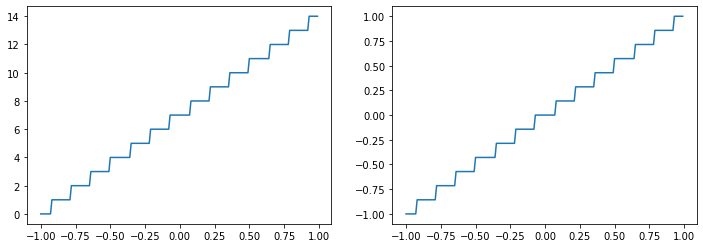

In [ ]:
x = np.arange(-1,1,0.01)
y = [np.where(linear_to_categorical(v)==1)[0][0] for v in x]
yy = [categorical_to_linear(linear_to_categorical(v)) for v in x]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
axs[0].plot(x,y)
axs[1].plot(x,yy)

In [ ]:
def read_data(directory_or_zipfile, json_fn_pattern, steering_key, throttle_key, image_fn_key):
  data_x_fn, data_y = [], []
  data_fns = sorted(get_names(directory_or_zipfile, json_fn_pattern))
  
  progress_bar = IntProgress(min=0, max=len(data_fns))
  display(progress_bar)

  for i, json_fn in enumerate(sorted(data_fns)):
    progress_bar.value = i
    
    if i % 100 == 0:
      clear_output(wait=True)
      bar_length = 40
      progress_percent = 100 * float(i)/len(data_fns)
      hashes = int(progress_percent * bar_length / 100)
      text = "Reading data [{}] {:.0f}%".format( "#" * hashes + "-" * (bar_length - hashes), progress_percent)
      print(text)

    json_data = read_json_file(directory_or_zipfile, json_fn)
    steering = json_data.get(steering_key)
    throttle = json_data.get(throttle_key)
    image_fn = json_data.get(image_fn_key)
    data_x_fn.append(image_fn)
    data_y.append(linear_to_categorical(steering))
    
  progress_bar.close()
  clear_output(wait=True)
  print("{} datasets read.".format(len(data_x_fn)))

  return data_x_fn, data_y

In [ ]:
def plot_data(directory_or_zipfile, data_x_fn, data_y, model=None):
  every_nth = round(len(data_x_fn)/(float(ncols)*nrows)+0.5)
  print("Showing every {}th picture of {}:".format(every_nth, len(data_x_fn)))
  ids = ImageDataSequence(directory_or_zipfile, data_x_fn, data_y, every_nth, shuffle=False)

  it = iter(ids)
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, 
                          figsize=(16, 15),
                          subplot_kw={'xticks': [], 'yticks': []})
  fig.subplots_adjust(left=0, right=1, hspace=0, wspace=0)
  for ax in axs.flat:
    images, ys = next(it, (None, None))
    if images is not None and ys is not None:
      x, y = images[0], ys[0]
      xMax = (x.shape[1]-1)
      yMax = (x.shape[0]-1)

      ax.imshow(x)

      steering = categorical_to_linear(y)
      ax.plot(2*[(steering+1)/2*(xMax-2)+1], [0,yMax], 'r', linewidth=1)

      if model is not None:
        categories = model.predict(np.expand_dims(x, axis=0), batch_size=1)[0]
        categories_x = (np.arange(STEERING_NUM_CATEGORIES))/(STEERING_NUM_CATEGORIES-1)*xMax
        categories_y = yMax*(1-categories/3)
        ax.step(categories_x, categories_y, where='mid', color='y')

        max_cat = np.argmax(categories)
        steering = max_cat/(STEERING_NUM_CATEGORIES-1) * 2 - 1
        ax.plot(2*[(steering+1)/2*(xMax-2)+1], [0,yMax], color='c', linestyle=':', linewidth=2)
        throttle = np.sum(categories[max_cat-1:max_cat+1])
        ax.plot([0,xMax], 2*[(1-throttle)*(yMax-2)+1], color='c', linestyle=':', linewidth=2)      

In [ ]:
class ImageDataSequence(Sequence):

  def __init__(self, directory_or_zipfile, X, y, batch_size, shuffle=False):
    self.directory_or_zipfile = directory_or_zipfile
    self.X, self.y = X, y
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.X))
    if self.shuffle == True:
      np.random.shuffle(self.indices)

  def __len__(self):
    """Return the number of batches in the Sequence."""
    return int(np.floor( len(self.X) / float(self.batch_size) ))

  def __getitem__(self, index):
    """Returns the batch at position `index` in the Sequence."""
    indices = self.indices[(index * self.batch_size):((index + 1) * self.batch_size)]
    batch_x = [self.X[i] for i in indices]
    batch_y = [self.y[i] for i in indices]

    x = np.array([read_image_file(self.directory_or_zipfile, filename) for filename in batch_x])
    y = np.array(batch_y)

    #print('indices=[', indices[0], indices[-1], '] index=', index, 'x.shape=', x.shape, 'y.shape=', y.shape)
    return x, y

In [ ]:
# read JeepDriver data
data_x_fn, data_y = read_data(directory_or_zipfile=DATA_DIR, 
                              json_fn_pattern='*train-*.json', 
                              steering_key='steering', 
                              throttle_key='throttle', 
                              image_fn_key='image')

20529 datasets read.


In [ ]:
len(data_x_fn), len(data_y)

(20529, 20529)

Each batch describes x.shape (128, 50, 160, 3) -> y.shape (128, 15)
x[0, 25, 100]= [206 192 189] , y[0]= [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Min=0 Max=255


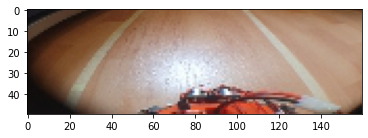

In [ ]:
ids = ImageDataSequence(DATA_DIR, data_x_fn, data_y, 128)
it = iter(ids)
x,y = next(it)
print("Each batch describes x.shape", x.shape, "-> y.shape", y.shape)
print("x[0, 25, 100]=", x[0, 25, 100, :], ", y[0]=", y[0])
print("Min={} Max={}".format(x.min(), x.max()))
#x[0,:,100,0] = 255 # indices are batch-y-x-color in rgb format
plt.imshow(x[0])

Showing every 214th picture of 20529:


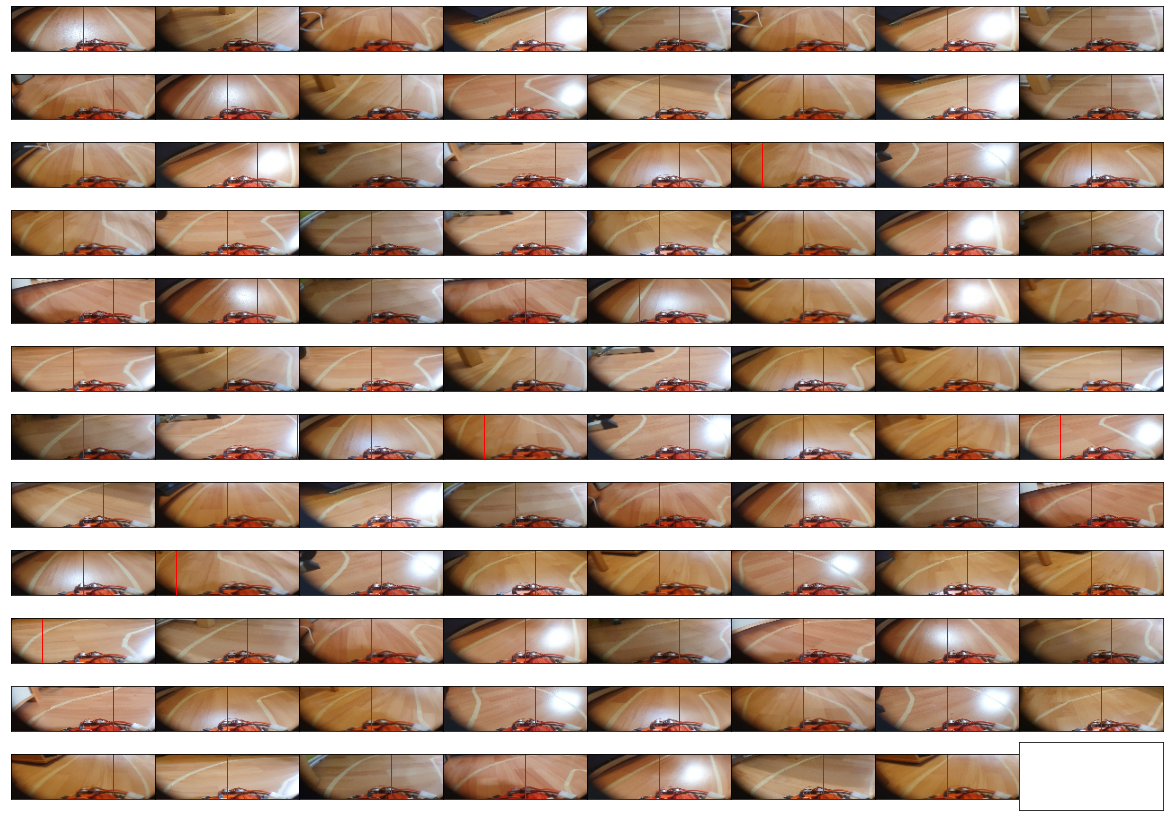

In [ ]:
plot_data(DATA_DIR, data_x_fn, data_y)

In [ ]:
img_in = Input(shape=(50, 160, 3), name='img_in')  # Input(shape=(120, 160, 3), name='img_in')
x = img_in
x = Convolution2D(24, (5, 5), strides=(2, 2), activation='relu', name='5x5-1')(x)
x = Convolution2D(34, (5, 5), strides=(2, 2), activation='relu', name='5x5-2')(x)
x = Convolution2D(48, (5, 5), strides=(1, 2), activation='relu', name='5x5-3')(x)
x = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu', name='3x3-1')(x)
x = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu', name='3x3-2')(x)

x = Flatten(name='flattened')(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.1)(x)  # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)
x = Dropout(.1)(x)  # Randomly drop out 10% of the neurons (Prevent overfitting)

# categorical output of the steering angle
steering_out = Dense(15, activation='softmax', name='steering_out')(x)

model = Model(inputs=[img_in], outputs=[steering_out])
model.compile(optimizer='adam',
              loss={'steering_out': 'categorical_crossentropy'},
              loss_weights={'steering_out': 0.9})

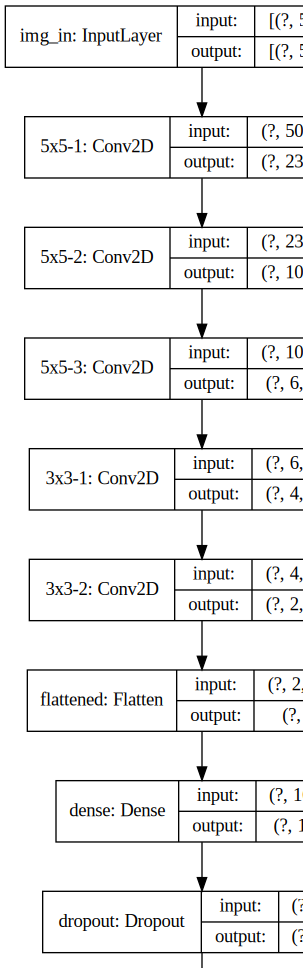

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
total_records = len(data_x_fn)
print(total_records, 'records total:')
train_total = int(total_records * TRAIN_TEST_SPLIT)
train_steps = train_total // BATCH_SIZE
print('training   data points: %5d total, %d images/batch * %3d steps = %d' % (train_total, BATCH_SIZE, train_steps, train_steps*BATCH_SIZE))
val_total = total_records - train_total
val_steps = val_total // BATCH_SIZE
print('validation data points: %5d total, %d images/batch * %3d steps = %d' % (val_total, BATCH_SIZE, val_steps, val_steps*BATCH_SIZE))

# mix all the data based on the same random seed value
np.random.seed(0)
indices = np.arange(total_records)
np.random.shuffle(indices)

# train/test split
train_indices = indices[0:train_total]
train_data_x_fn = [data_x_fn[index] for index in train_indices]
train_data_y = [data_y[index] for index in train_indices]
val_indices = indices[train_total:total_records]
val_data_x_fn = [data_x_fn[index] for index in val_indices]
val_data_y = [data_y[index] for index in val_indices]

training_data_generator = ImageDataSequence(DATA_DIR, train_data_x_fn, train_data_y, BATCH_SIZE)
validation_data_generator = ImageDataSequence(DATA_DIR, val_data_x_fn, val_data_y, BATCH_SIZE)

20529 records total:
training   data points: 16423 total, 128 images/batch * 128 steps = 16384
validation data points:  4106 total, 128 images/batch *  32 steps = 4096


In [ ]:
save_best = ModelCheckpoint(CHECKPOINT_PATH,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=.0005,
                           patience=5,
                           verbose=1,
                           mode='auto')

history = model.fit_generator(
    training_data_generator,
    steps_per_epoch=train_steps,  # number of batches processed per epoch
    epochs=100,
    verbose=2,           # 0 = silent, 1 = progress bar, 2 = one line per epoch
    validation_data=validation_data_generator,
    validation_steps=val_steps,
    callbacks=[save_best, early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.28627, saving model to gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze/Model/checkpoint.hdf5
128/128 - 16s - loss: 1.6853 - val_loss: 1.2863
Epoch 2/100

Epoch 00002: val_loss improved from 1.28627 to 1.16984, saving model to gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze/Model/checkpoint.hdf5
128/128 - 12s - loss: 1.2705 - val_loss: 1.1698
Epoch 3/100

Epoch 00003: val_loss improved from 1.16984 to 1.16610, saving model to gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze/Model/checkpoint.hdf5
128/128 - 12s - loss: 1.1772 - val_loss: 1.1661
Epoch 4/100

Epoch 00004: val_loss improved from 1.16610 to 1.11686, saving model to gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze/Model/checkpoint.hdf5
128/128 - 12s - loss: 1.1424 - val_loss: 1.1169
Epoch 5/100

Epoch 00005: val_loss improved from 1.11686 to 1.09153, saving model to gdrive/My Drive/Aut

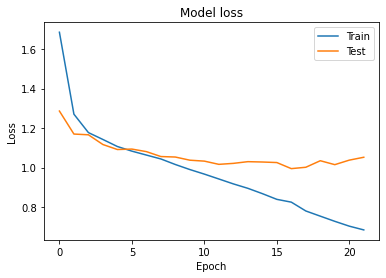

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Showing every 43th picture of 4106:


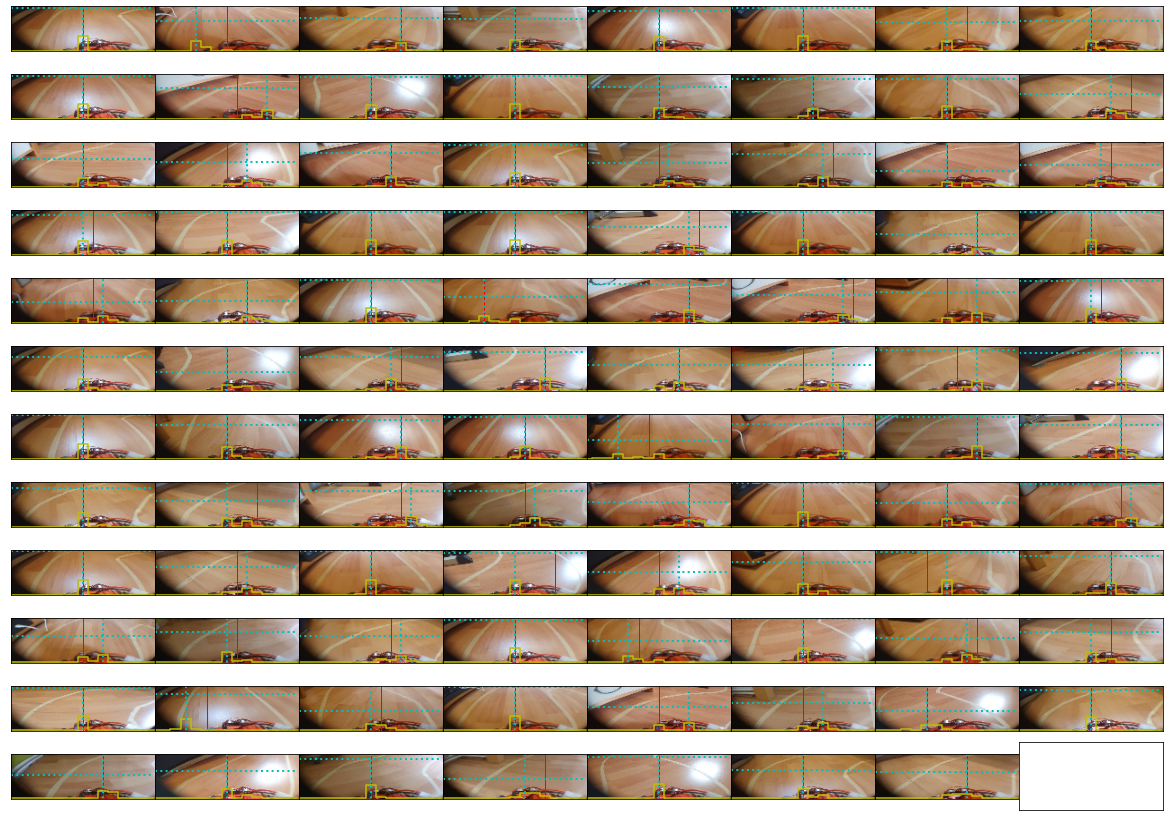

In [ ]:
plot_data(DATA_DIR, val_data_x_fn, val_data_y, model)

In [ ]:
print("Saving trained model to {}".format(MODEL_PATH))
model.save(MODEL_PATH)
# load model with model = load_model(os.path.join(MODEL_PATH, 'keras-model.hdf5'))

Saving trained model to gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze/Model/keras-model.hdf5


In [ ]:
import tensorflow as tf
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(MODEL_PATH)
#converter = tf.contrib.lite.TFLiteConverter.from_keras_model_file(MODEL_PATH)
#converter = tf.lite.TFLiteConverter.from_keras_model_file(MODEL_PATH)
#converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()
open(TFLITE_PATH, "wb").write(tflite_model)


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpfa7umt5o/assets
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /tmp/tmpfa7umt5o/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: img_in


1204708

In [ ]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

In [ ]:
setting_pattern = "index.json"
settings = get_names(DATA_DIR, setting_pattern)
print(settings)
config_pattern = "configurationPicture.jpg"
configuration_picture = get_names(DATA_DIR, config_pattern)
print(configuration_picture)
nn_path = os.path.join(ANDROID_DIR, 'NN')
if not os.path.lexists(nn_path):
  os.mkdirs(nn_path)
print(nn_path)
from shutil import copyfile
copyfile(settings[0], os.path.join(nn_path, setting_pattern))
copyfile(configuration_picture[0], os.path.join(nn_path, config_pattern))
copyfile(TFLITE_PATH, os.path.join(nn_path, 'model.tflite'))
import zipfile
zipf = zipfile.ZipFile(os.path.join(ANDROID_DIR, 'nn.zip'), 'w', zipfile.ZIP_DEFLATED)
zipdir(nn_path, zipf)
zipf.close()

['/content/data/20200906-132753-741/index.json']
['/content/data/20200906-132753-741/configurationPicture.jpg']
gdrive/My Drive/Autonomes Fahrzeug/Neuronale Netze/Android/NN


In [ ]:
COREML_PATH = os.path.join(MODEL_DIR, 'autodriver.mlmodel')

!pip install coremltools
import coremltools

In [ ]:
coreml_model = coremltools.converters.keras.convert(MODEL_PATH, 
                                                    input_names="img_in",
                                                    image_input_names="img_in",
                                                    is_bgr=False)
#coreml_model = ct.convert(MODEL_PATH)

TypeError: ignored